# Introduction à l'apprentissage par renforcement
# TP 1 - les manchots multi-bras

1/4 de la note finale est liée à la mise en forme : 

* pensez à nettoyer les outputs inutiles (installation, messages de débuggage, ...)
* soignez vos figures : les axes sont-ils faciles à comprendre ? L'échelle est adaptée ? 
* commentez vos résultats : vous attendiez-vous à les avoir ? Est-ce étonnant ? Faites le lien avec la théorie.

Ce TP reprend l'exemple d'un médecin et de ses vaccins. Vous allez comparer plusieurs stratégies et trouver celle optimale.
Un TP se fait seul ou en binôme. Aucun groupe de plus de 2 personnes. 

Vous allez rendre le TP depuis un lien GitHub avec ce notebook mais une version du rapport exportée en PDF & HTML. 

In [ ]:
! pip install matplotlib tqdm numpy ipympl opencv-python
!jupyter labextension install @jupyter-widgets/jupyterlab-manager
!jupyter labextension install jupyter-matplotlib

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline 

import typing as t
import math
import torch
import numpy as np
from tqdm.auto import trange, tqdm
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import cv2
from IPython.display import display, clear_output

torch.random.manual_seed(0)

K = 5 # num arms

# Présentation du problème

In [2]:
class ArmBernoulli:
    def __init__(self, p: float):
        """
        Vaccine treatment following a Bernoulli law (mean is p and variance is p(1-p)
        Args:
             p (float): mean parameter
             
        >>> torch.random.manual_seed(random_state)        
        >>> arm = ArmBernoulli(0.5)
        >>> arm.sample(5)
        tensor([ True, False,  True,  True,  True])
        """
        self.immunity_rate = p

    def sample(self, n: int = 1):
        return torch.rand(n) < self.immunity_rate
    
    def __repr__(self):
        return f'<ArmBernoulli p={self.immunity_rate}' 

def generate_arms(num_arms: int):
    means = torch.rand(K)
    MAB = [ArmBernoulli(m) for m in means]
    assert MAB[0].immunity_rate == means[0]
    assert (MAB[0].sample(10) <= 1).all() and (MAB[0].sample(10) >= 0).all() 
    return MAB

MAB = generate_arms(K)

Ce TP reprend l'exemple du médecin présenté en cours.


**Q1. Créez une fonction pour trouver $\mu^*$ à partir d'un `MAB`. Comment est définie la récompense $R_k$ ? Que représente concrètement le regret dans le contexte de ce TP ?**

In [3]:
#set random_state to 0
torch.manual_seed(0)

MAB = generate_arms(K)
best_arm = max(MAB, key=lambda MAB: MAB.immunity_rate)
arms_immunity_rate = [arm.immunity_rate.item() for arm in MAB]

print(f'Immunty_rate for random_state == 0 is : {arms_immunity_rate}')
print('----')
print(f'Best vaccin is : {best_arm}')

Immunty_rate for random_state == 0 is : [0.49625658988952637, 0.7682217955589294, 0.08847743272781372, 0.13203048706054688, 0.30742281675338745]
----
Best vaccin is : <ArmBernoulli p=0.7682217955589294


**Définition récompense R_k**  
La récompense R_k est définit par une loi de Bernouilli.

**Représentation du regret**  
Le regret représente la différence de personne qui aurait du être immunisé après l'injection du vaccin mais qui aurait du l'être

**Note importante :** pour la suite, les résultats seront généralement réalisés avec 100 initialisations différentes du MAB (tous les MAB ont 5 vaccins mais des taux d'immunistation différent) pour réduire le bruit de simulation. Concrètement, on exécutera au moins 100x `generate_arms`.

# I. Cas classique des bandits manchots 

## I.a. Solution Gloutonne

Le médecin fonctionne sur deux phases :

1. **Exploration :** Le médecin calcule le taux d'immunisation empirique sur les N premiers patients en administrant le même nombre de fois chaque vaccin :

$$\hat{\mu_i}[0\rightarrow N] = \frac{1}{T_i} \sum_{k=0}^{N-1} \chi_{v_k,i}R_k,$$

avec $T_i = \sum_{k=0}^{N-1} \chi_{v_k,i}$.


2. **Exploitation :** Le vaccin $v_i = \arg\max_j \hat{\mu_j}[0\rightarrow N]$ est utilisé pour les M patients suivants.

**Q2. Implémentez cette solution avec N = 50 et M = 500 et testez-la avec 100 MAB. On souhaite savoir si vous trouvez le vaccin optimal à l'issue d'une phase d'exploration. Quelle est l'espérance empirique de cette variable ? Et son écart-type ? Calculez de même l'espérance et l'écart-type du regret sur vos 100 simulations.**

Pour rappel, le regret est défini par :

$$r_n = n\mu^* - \sum_{k=0}^{n-1} R_k$$

**Attention :** $n$ est le nombre total de patients, donc ici $N + M$.

In [4]:
#Déclaration des constantes
N = 50
M = 500
number_MAB = 100

In [39]:
def getBestVaccin(MAB):
    best_arm = max(MAB, key=lambda MAB: MAB.immunity_rate)
    best_index = MAB.index(best_arm)
    return best_index

def getBestResult(vac_results):
    return vac_results.index(max(vac_results))

def Vaccin_arms(MAB, n):
    patient = []
    for i in range(len(MAB)):
        vaccins = MAB[i].sample(n)
        vaccins = [1 if vaccin else 0 for vaccin in vaccins]
        patient += (vaccins)
    return patient

def Exploration(MAB, n=N):  #return [1,0,...],
    Ti = n // len(MAB)  #Distribution uniforme
    vaccins = Vaccin_arms(MAB, Ti)
    vac_results = []
    for i in range(len(MAB)):
        sum = 0
        for j in range(Ti):
            ind = i * Ti + j
            sum += vaccins[ind]
        vac_results.append(sum / Ti)
    return vac_results

def Exploitation(MAB, vac_results, m=M):  #return [1,0 ...], for best vaccin
    arg_max = getBestResult(vac_results)
    vaccins = MAB[arg_max].sample(m)
    vaccins = [1 if vaccin else 0 for vaccin in vaccins]
    return vaccins

def gloutonne(number_MAB=100):
    exploration_var = []
    regret = []
    for _ in range(number_MAB):
        MAB = generate_arms(K)
        exploration = Exploration(MAB, N)
        best_arm = getBestVaccin(MAB)
        if (best_arm == getBestResult(exploration)):
            exploration_var.append(1)
        else:
            exploration_var.append(0)    

        exploitation = Exploitation(MAB, exploration, M)
        Ti = N // len(MAB)
        r_N = (N + M) * MAB[best_arm].immunity_rate - ((exploration[best_arm] * Ti) + sum(exploitation))
        regret.append(r_N)
    return exploration_var, regret

exploration_var, regret = gloutonne(number_MAB)
print(f'Espérence empirique de l\'exploration : {np.mean(exploration_var)}')
print(f'Ecart-type de l\'exploration : {np.std(exploration_var)}')
print(f'Espérence empirique du regret : {np.mean(regret)}')
print(f'Ecart-type du regret : {np.std(regret)}')

Espérence empirique de l'exploration : 0.69
Ecart-type de l'exploration : 0.46249324319388707
Espérence empirique du regret : 45.18913269042969
Ecart-type du regret : 31.1195125579834


**Q3. On étudie maintenant l'influence de la taille du training set $N$. On considère que N+M est une constante, puis on fait varier N entre K et M. Calculez le regret pour ces différentes tailles du training set  différents MAB et representez le regret moyen, le regret min et max (vous devriez trouver une courbe en U ou en V pour le regret moyen). Quelle est la taille optimale du training set ?**

In [43]:
# Constantes
n_total = N + M

def gloutonne_2():
    regret = []
    n = K #5
    m = n_total - n #545
    MAB = generate_arms(K)
    while n <= m:
        exploration = Exploration(MAB, n)
        exploitation = Exploitation(MAB, exploration, m)
        
        #regret
        Ti = n // len(MAB)
        best_arm = getBestVaccin(MAB) 
        r_N = (n + m) * MAB[best_arm].immunity_rate - ((exploration[best_arm] * Ti) + sum(exploitation))
        regret.append(r_N.item())
        n = n + K
        m = m - K
    return regret

import matplotlib.pyplot as plt

def plot_regret(regret):
    means = [np.mean(regret)] * len(regret)

    plt.figure(figsize=(10, 6))
    plt.plot(regret, marker='o', linestyle='-', color='b')
    plt.plot(means, linestyle='-', color='r')

    plt.xlabel('Iterations')
    plt.ylabel('Regret')
    plt.title('Courbe du Regret')

    plt.grid(True)
    plt.show()

In [48]:
#changer to rgret sur 1 itérations
regret_v2 = gloutonne_2()
print('regret min :', min(regret_v2), ' | regret max :', max(regret_v2), ' | regret moyen :', np.mean(regret_v2))

regret min : 4.0732421875  | regret max : 412.0732421875  | regret moyen : 125.70960582386364


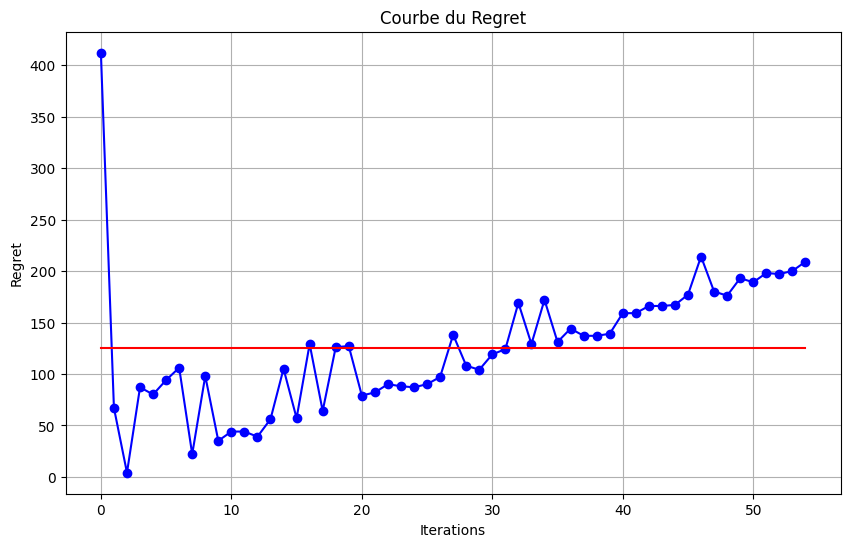

In [49]:
plot_regret(regret_v2)

**Réponse**  
La taille optimal du training set est de N = 20

**Q4. On propose d'améliorer l'algorithme précédant en mettant à jour les taux d'immunisation empiriques $\hat{\mu}_i$ pendant la phase d'exploitation (algorithme *greedy*). Concrètement, à chaque nouvel patient, on lui administre le meilleur vaccin selon les stats. Notez vous une amélioration du regret ? Proposez un exemple où les taux d'immunisation du MAB ne changent rien.** 

Espérence empirique du regret : 36.89608383178711
Ecart-type du regret : 12.399407386779785


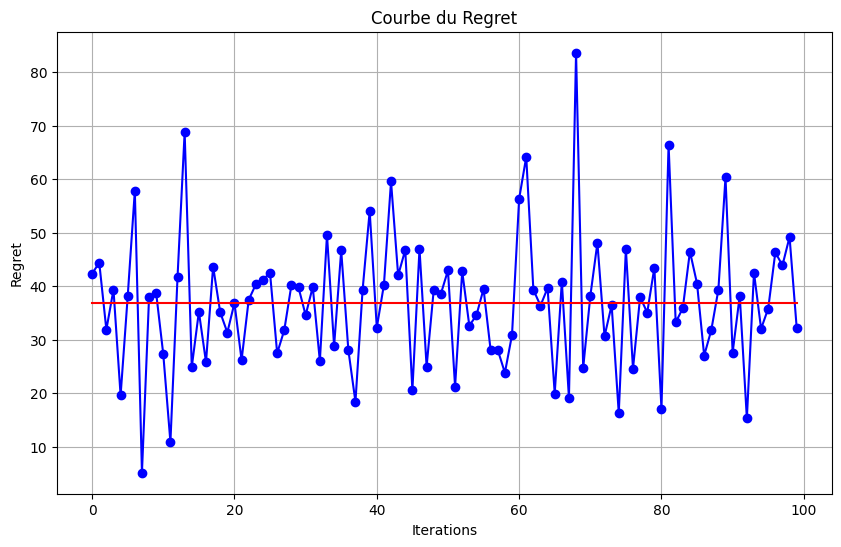

In [22]:
#changer sur 1 itérations
def Exploitation_greedy(MAB, immunity_rate):
    vaccins = []
    Ti = N // len(MAB)
    hist = [Ti] * len(MAB)  # size -> 5
    for _ in range(M):
        best_arm = getBestResult(immunity_rate)
        arm = MAB[best_arm].sample(1).item()
        hist[best_arm] += 1
        immunity_rate[best_arm] = (immunity_rate[best_arm] * (hist[best_arm] - 1) + arm) / hist[best_arm]
        vaccins.append(arm)
    vaccins = [1 if vaccin else 0 for vaccin in vaccins]
    return vaccins

def gloutonne_greedy():
    regret = []
    for _ in range(number_MAB):
        MAB = generate_arms(5)
        exploration = Exploration(MAB)
        best_arm = getBestVaccin(MAB)   

        exploitation = Exploitation_greedy(MAB, exploration)
        Ti = N // len(MAB)
        r_N = (N + M) * MAB[best_arm].immunity_rate - ((exploration[best_arm] * Ti) + sum(exploitation))
        regret.append(r_N)
    return regret

regret_greedy = gloutonne_greedy(number_MAB)
print(f'Espérence empirique du regret : {np.mean(regret_greedy)}')
print(f'Ecart-type du regret : {np.std(regret_greedy)}')
plot_regret(regret_greedy)


**Réponse**  
La figure montre le résultats sur 100 itérations contenant tous 5 MAB aléatoires.  
Nous remarquons que l'écart-type du regret diminue drastiquement.  
Quant à la moyenne du regret, elle ne diminue que légèrement (\< 10). Les résultats sont donc dans l'ensemble meilleur avec cette algorithme (greedy).  

Cette mise à jour ne change rien dans le cadre où le meilleur vaccin théorique est trouvé dès le début (à la première itération).

**Q5. Nouvelle amélioration : à chaque nouveau patient, on choisit si on lui administre le meilleur vaccin avec une probabilité $\epsilon$ ou un vaccin aléatoire ($p=1-\epsilon$). Vérifiez si vous obtenez un meilleur résultat avec N = 0 ou N > 0. À votre avis, à quoi sert $\epsilon$ ?** 

In [9]:
#changer tester avec les meme MAB
#Constantes
eps = 0.8

def Exploitation_proba(MAB, immunity_rate, n=N, m=M):
    vaccins = []
    Ti = n // len(MAB)
    hist = [Ti] * len(MAB)
    for _ in range(m):
        if (torch.rand(1) > eps):
            best_arm = torch.randint(0, len(MAB), (1,)).item()
        else:
            best_arm = getBestResult(immunity_rate)
        arm = MAB[best_arm].sample(1).item()
        hist[best_arm] += 1
        immunity_rate[best_arm] = (immunity_rate[best_arm] * (hist[best_arm] - 1) + arm) / hist[best_arm]
        vaccins.append(arm)
    vaccins = [1 if vaccin else 0 for vaccin in vaccins]
    return vaccins

def gloutonne_proba(number_MAB=100, n=N, m=M):
    regret = []
    for _ in range(number_MAB):
        MAB = generate_arms(K)
        if (n == 0):
            exploration = [0] * len(MAB)
        else:
            exploration = Exploration(MAB, n)
        
        best_arm = getBestVaccin(MAB)
        exploitation = Exploitation_proba(MAB, exploration, n=n)
        Ti = n // len(MAB)
        r_N = (n + m) * MAB[best_arm].immunity_rate - ((exploration[best_arm] * Ti) + sum(exploitation))
        regret.append(r_N)
    return regret

regret_eps= gloutonne_proba(number_MAB, n=N)
regret_eps_0 = gloutonne_proba(number_MAB, n=0)
print(f'Moyenne du regret pour N > 0 : {np.mean(regret_eps)}')
print(f'Moyenne du regret pour N = 0 : {np.mean(regret_eps_0)}')
    

Moyenne du regret pour N > 0 : 70.21436309814453
Moyenne du regret pour N = 0 : 42.77372741699219


**Réponse**  

Nous obtenons de meilleurs résulats avec N = 0. Cependant, le regret est moins bon avec l'amélioration qu'avec la méthode greedy classique  

Epsilon permet de tester des d'autres vaccins, afin de ne pas être bloqué sur un maximum local (recherche ailleurs), c'est à dire, il établie une recherche aléatoire pour trouver le le bras avec la meilleure immunity rate.

## I.b. Borne inférieure de Lai & Robbins [Lai et Robbins, 1985]

Lai et Robbins [Lai et Robbins, 1985] considère une classe d'algorithmes $\pi$ pour résoudre ce type de problèmes.

Ils ont trouvé une borne inférieure sur les récompenses cumulées en valeur asymptotique :

$$\lim_{n\rightarrow \infty} \inf_{\pi} \frac{\sum_{k=0}^{n-1} R_k}{\log n} \geq \sum_{i~\text{tel que}~\mu_i \lt \mu^*} \frac{\mu^∗−\mu_i}{\text{KL}(\mu_i, \mu^*)}  :=C(\mu)$$
 
 avec $\text{KL}(x, y) = x \log(x/y) + (1 − x) \log((1 − x)/(1 − y))$ (distance de Kullback-Leibler) et  $\sum_{k=0}^{n-1} R_k$ la récompense obtenue sur $n$ patients.
 
 
**Q6. Justifiez pourquoi on peut en déduire que le regret d'un algorithme raisonnable sera au pire logarithmique.**

**Réponse**  
La borne inférieure de Lai et Robbins montre que la récompense cumulée d'un algorithme efficace suit asymptotiquement une croissance proportionnelle à $log(n)$ :

$$
\lim_{n \to \infty} \inf_{\pi} \frac{\sum_{k=0}^{n-1} R_k}{\log n} \geq C(\mu)
$$

Cela signifie que pour tout algorithme, la récompense cumulée $\sum_{k=0}^{n-1} R_k$ ne peut pas croître plus lentement qu'une fonction logarithmique de n.

Nous calculons le regret pour la borne de Lai & Robbins : 
$$
R(n) \leq n\mu^* - \sum_{i~\text{tel que}~\mu_i \lt \mu^*} \frac{\mu^∗−\mu_i}{\text{KL}(\mu_i, \mu^*)} \log n
$$

Le regret, $R(n)$, qui d'après la borne inférieure, $\sum_{k=0}^{n-1} R_k$ croît au moins comme $C(\mu) \log n$. Par conséquent, le regret est dominé par un terme $n \mu^* - C(\mu) \log n$, ce qui implique que $R(n)$ croît au pire logarithmiquement.  

Donc, un algorithme raisonnable aura un regret logarithmique en $n$.

**Q7. Tracez le regret issu de la borne de Lai & Robbins et comparez le au regret obtenu avec l'algorithme glouton.**

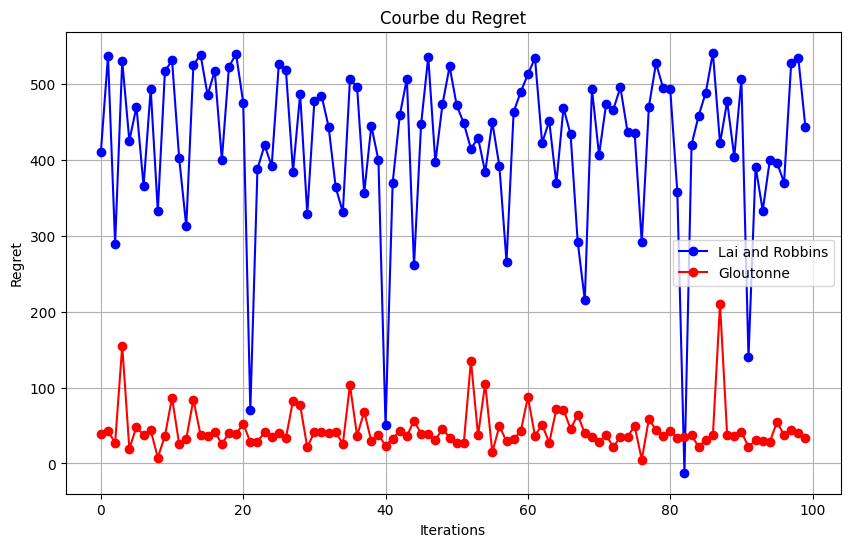

In [228]:
def kl_divergence(x, y):
    kl = x * np.log(x / y) + (1 - x) * np.log((1 - x) / (1 - y))
    return kl

def lai_robbins_regret(n, arms):
    mu_star = max(arms)
    C_mu = 0
    for mu_i in arms:
        if mu_i < mu_star:
            C_mu += (mu_star - mu_i) / kl_divergence(mu_i, mu_star)
    regret = n * mu_star - C_mu * math.log(n)
    return regret

def gloutonne_MAB(MAB):
    exploration = Exploration(MAB, N)
    best_arm = getBestVaccin(MAB) 
    exploitation = Exploitation(MAB, exploration, M)
    Ti = N // len(MAB)
    r_N = (N + M) * MAB[best_arm].immunity_rate - ((exploration[best_arm] * Ti) + sum(exploitation))
    return r_N

def plot_compare_regrets(regret_lay, regret_gloutonne):
    plt.figure(figsize=(10, 6))
    plt.plot(regret_lay, marker='o', linestyle='-', color='b')
    plt.plot(regret_gloutonne, marker='o', linestyle='-', color='r')

    plt.xlabel('Iterations')
    plt.ylabel('Regret')
    plt.title('Courbe du Regret (100 itérations)')

    plt.legend(['Lai and Robbins', 'Gloutonne'])

    plt.grid(True)
    plt.show()

def compare():
    regret_lay_robbins = []
    regret_gloutonnes = []
    for _ in range(number_MAB):
        arms = generate_arms(K)
        immunity_rate = [arm.immunity_rate for arm in arms]
        regret_lay = lai_robbins_regret(N + M, [e.item() for e in immunity_rate])
        regret_gloutonne = gloutonne_MAB(arms)
        regret_lay_robbins.append(regret_lay)
        regret_gloutonnes.append(regret_gloutonne)
        
    plot_compare_regrets(regret_lay_robbins, regret_gloutonnes)

compare()

**Réponse**  
Nous constatons que l'algorithme glouton obtient de meilleur résultat que l'algorithme Lay & Robbins.

## I.c. Upper Confidence Bounds

Cet algorithme améliore la version précédente en ajoutant un biais lié à la fréquentation de chaque vaccin :

$$
\bar{\mu}_i = \hat{\mu}_i + \sqrt{\frac{C\log{n}}{T_i}}
$$,

avec $C=2$.


**Q8. Implémentez la modification de cet algorithme. Observez un intérêt à conserver $N > 0$ ? Et $\epsilon < 1$ ? Expliquez pourquoi.**

Dans la suite, on prendra $N = 0$ et $\epsilon = 1$.

In [10]:
def Exploration_UCB(MAB, n=N, m=M, C=2):
    Ti = n // len(MAB)  #Distribution uniforme
    vaccins = Vaccin_arms(MAB, Ti)
    vac_results = []
    n_total = n + m
    for i in range(len(MAB)):
        sum = 0
        for j in range(Ti):
            ind = i * Ti + j
            sum += vaccins[ind]
        reward = sum / Ti
        r_bias = reward + math.sqrt(C * math.log(n_total) / Ti)
        vac_results.append(r_bias)
    return vac_results

def Exploitation_UCB(MAB, immunity_rate, n=N, m=M, C=2, eps=0.8):
    vaccins = []
    Ti = n // len(MAB)
    hist = [Ti] * len(MAB)
    n_total = n + m
    for _ in range(m):
        if (torch.rand(1) > eps):
            best_arm = torch.randint(0, len(MAB), (1,)).item()
        else:
            best_arm = getBestResult(immunity_rate)
        arm = MAB[best_arm].sample(1).item()
        hist[best_arm] += 1
        bias = math.sqrt(C * math.log(n_total) / hist[best_arm])
        im_ = immunity_rate[best_arm] - bias
        immunity_rate[best_arm] =((im_ * (hist[best_arm] - 1) + arm) / hist[best_arm]) + bias
        vaccins.append(arm)
    vaccins = [1 if vaccin else 0 for vaccin in vaccins]
    return vaccins

def UCB(number_MAB=100, n=N, m=M, eps=0.8):
    regret = []
    for _ in range(number_MAB):
        MAB = generate_arms(K)
        if (n == 0):
            exploration = [0] * len(MAB)
        else:
            exploration = Exploration_UCB(MAB, n)
        
        best_arm = getBestVaccin(MAB)
        exploitation = Exploitation_UCB(MAB, exploration, n=n, eps=eps)
        Ti = n // len(MAB)
        r_N = (n + m) * MAB[best_arm].immunity_rate - ((exploration[best_arm] * Ti) + sum(exploitation))
        regret.append(r_N)
    return regret

In [26]:
def multi_plot_regret(total_regrets):

    colors = ['b', 'r', 'g', 'y']
    labels = ['epsilon = 0.2', 'epsilon = 0.5', 'epsilon = 0.8', 'epsilon = 1']

    plt.figure(figsize=(15, 8))

    for i in range(len(total_regrets)):
        plt.plot(total_regrets[i], marker='x', linestyle='--', color=colors[i], label=labels[i])

    plt.legend()

    plt.xlabel('Taille de N')
    plt.ylabel('Regret')
    plt.title('Courbe du Regret')

    plt.grid(True)
    plt.show()

def UCB_regret_test():
    eps = [0.2, 0.5, 0.8, 1]

    regrets_total = []
    n_total = N + M
    for e in eps:
        regret_eps = []
        for n in range(0, M, 5):
            m = n_total - n
            UCB_regret = UCB(50, eps=e, n=n, m=m)
            regret_eps.append(np.mean(UCB_regret))
        regrets_total.append(regret_eps)
    return regrets_total

In [27]:
UCB_regret = UCB_regret_test()

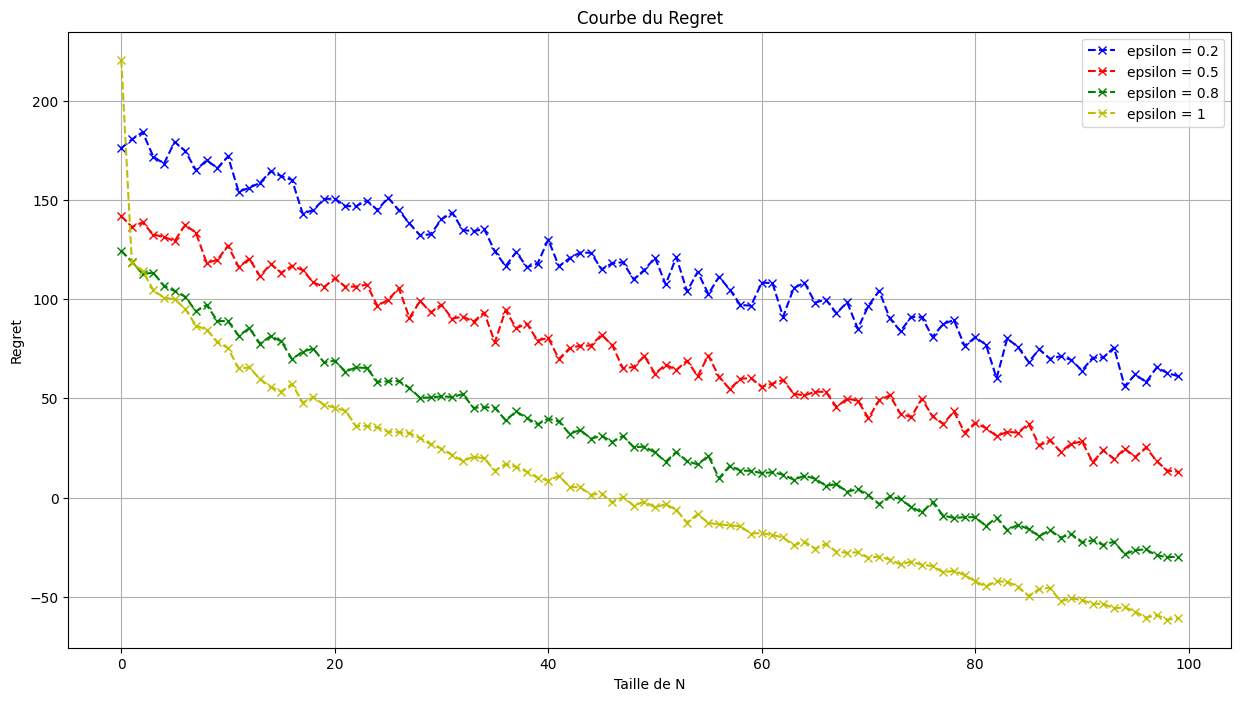

In [29]:
multi_plot_regret(UCB_regret)

*[Ajoutez votre commentaire ici]*

**Q9. Tracez sous la forme d'une animation l'évolution des taux d'immunisation empirique (fig. de gauche) et l'évolution du regret (fig. droite). Dans la figure de gauche, vous representerez $\bar{\mu}_i$ et $\hat{\mu}_i$ pour chaque vaccin.**

In [ ]:
# sur 1 itérations
def UCB(number_MAB=100, n=N, m=M, eps=0.8):
    regret = []
    for _ in range(number_MAB):
        MAB = generate_arms(K)
        if (n == 0):
            exploration = [0] * len(MAB)
        else:
            exploration = Exploration_UCB(MAB, n)
        
        best_arm = getBestVaccin(MAB)
        exploitation = Exploitation_UCB(MAB, exploration, n=n, eps=eps)
        Ti = n // len(MAB)
        r_N = (n + m) * MAB[best_arm].immunity_rate - ((exploration[best_arm] * Ti) + sum(exploitation))
        regret.append(r_N)
    return regret

*[Ajoutez votre commentaire ici]*

**Q10. Reprenez la question Q5 avec cette algorithme. Concluez sur l'utilité (ou l'inutilité) de la phase d'exploration. Comparez les performances d'UCB avec celles de l'algorithme glouton.**

In [ ]:
# Q4 -> test avec N jusqu'a M

*[Ajoutez votre commentaire ici]*

**Q11. Testez différentes valeurs pour $C$ et trouvez sa valeur optimale expérimentalement.**

In [ ]:
# tester différentes valeurs de C [0.5, 1,2,5,10]

*[Ajoutez votre commentaire ici]*

# Echantillonnage de Thomson

Cet algorithme propose de modéliser la variable aléatoire de chaque vaccin avec une loi $\beta$ dont les paramètres $a$ et $b$ correspondent au nombre de patients que le vaccin a immunisés (resp. non immunisés).

Pour chaque patient, on tire un valeur aléatoire pour la loi $\beta$ décrivant chaque vaccin, puis on choisit le vaccin avec la plus grande valeur tirée. 

**Q12. Implémentez cet algorithme. En testant plusieurs valeurs de $N$, montrez que la phase d'exploration précédente a un impact très limité. Cela veut-il dire que l'algorithme ne contient pas d'initialisation ?**

In [102]:
from torch.distributions import Beta

#Pas fini (pas sur du résultat)

def Thompson(MAB, n):

    # Initialisation
    alpha = torch.ones(K)
    beta = torch.ones(K)
    #arm_selection_count = torch.zeros(K)

    rewards = []
    #Exploration
    for _ in range(n):
        samples = torch.tensor([Beta(alpha[i], beta[i]).sample() for i in range(K)])
        
        chosen_arm = torch.argmax(samples).item()
        reward = MAB[chosen_arm].sample(1).item()
        
        alpha[chosen_arm] += reward
        beta[chosen_arm] += 1 - reward
        rewards.append(reward)

    #Exploitation
    samples = torch.tensor([Beta(alpha[i], beta[i]).sample() for i in range(K)])
    chosen_arm = torch.argmax(samples).item()
    for _ in range(M):
        # samples = torch.tensor([Beta(alpha[i], beta[i]).sample() for i in range(K)])
        # chosen_arm = torch.argmax(samples).item()
        reward = MAB[chosen_arm].sample(1).item()
        rewards.append(reward)
        
        # alpha[chosen_arm] += reward
        # beta[chosen_arm] += 1 - reward
        
    best_arm = getBestVaccin(MAB)
    regret = (n + M) * MAB[best_arm].immunity_rate - sum(rewards)
    
    return alpha, beta, regret


*[Ajoutez votre commentaire ici]*

**Q13. Tracez sous la forme d'une animation l'évolution des taux d'immunisation empirique (fig. de gauche) et l'évolution du regret (fig. droite). Dans la figure de gauche, vous representerez le taux d'immunisation empirique  pour chaque vaccin avec un [graphique en violon](https://en.wikipedia.org/wiki/Violin_plot) qui représente la loi beta associée à chaque vaccin.**

*[Ajoutez votre commentaire ici]*

**Q14. Comparez le regret avec les autres algorithmes.**

*[Ajoutez votre commentaire ici]*

# Conclusion

**Q15. Calculez le regret des algorithmes glouton, UCB & Thomson lorsqu'il y a un grand nombre de vaccins disponibles (K=100) (on prendra N=100). Faites le lien avec la [malédiction de la dimension](https://fr.wikipedia.org/wiki/Fl%C3%A9au_de_la_dimension).**

*[Ajoutez votre commentaire ici]*